# Предсказание рисков сердечного приступа

## Описание проекта
**Необходимо разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней**

## Импорт необходимых библиотек и объявление констант

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Catboost -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV)


from sklearn.preprocessing import (StandardScaler,   
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                    RobustScaler,
                                    MinMaxScaler)


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (make_scorer,
                             roc_auc_score,
                             f1_score,
                             precision_score,
                             accuracy_score,
                             recall_score, 
                             classification_report, 
                             confusion_matrix,
                             precision_recall_curve, 
                             average_precision_score)


from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scipy.stats as stats

from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE

import os
import phik
import shap
import joblib

TEST_SIZE = 0.25
RANDOM_STATE = 666


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format','{:.4f}'.format)

custom_palette = [
    '#2A5CAA',  # глубокий синий
    '#E63946',  # яркий красный
    '#8B0000',  # тёмно-красный   
    '#457B9D',  # мягкий сине-бирюзовый
    '#A8DADC',  # нежный бирюзовый
    '#F1FAEE',  # молочный белый
    '#B53844',  # глиняный тёплый красный
    '#3A3A3A'   # глубокий графит
]




sns.set_palette(custom_palette)

# Загрузка данных и ознакомление с ними

In [5]:
df_train = pd.read_csv('heart_train.csv')
df_test = pd.read_csv('heart_test.csv')

In [6]:
df_train.shape

(8685, 28)

In [7]:
df_train.head()

Unnamed: 0    Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0 0.3596       0.7321      0.0742    1.0000          1.0000   
1           1 0.2022       0.3250      0.0477    1.0000          1.0000   
2           2 0.6067       0.8607      0.0559    1.0000          0.0000   
3           3 0.7303       0.0071      0.0532    0.0000          0.0000   
4           4 0.7753       0.7571      0.0220    0.0000          0.0000   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0   1.0000   1.0000               1.0000                   0.5355     1   
1   0.0000   0.0000               1.0000                   0.0687     2   
2   1.0000   1.0000               1.0000                   0.9440     2   
3   1.0000   0.0000               1.0000                   0.6970     0   
4   1.0000   0.0000               1.0000                   0.4129     1   

   Previous Heart Problems  Medication Use  Stress Level  \
0                   1.0000          0.0000        8.0000   
1                   1.0000          0.0000        9.0000   
2                   1.0000          1.0000        6.0000   
3                   0.0000          1.0000        3.0000   
4                   0.0000          0.0000        8.0000   

   Sedentary Hours Per Day  Income    BMI  Triglycerides  \
0                   0.2257  0.1059 0.4592         0.9792   
1                   0.2899  0.1642 0.1171         0.5156   
2                   0.5501  0.5987 0.3736         0.0130   
3                   0.3310  0.0776 0.0497         0.1312   
4                   0.5246  0.3420 0.8304         0.0701   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                           3.0000               0.3333   
1                           3.0000               0.8333   
2                           2.0000               1.0000   
3                           0.0000               0.3333   
4                           5.0000               1.0000   

   Heart Attack Risk (Binary)  Blood sugar  CK-MB  Troponin  Gender  \
0                      0.0000       0.2270 0.0482    0.0365    Male   
1                      0.0000       0.1502 0.0176    0.0002  Female   
2                      0.0000       0.2270 0.0482    0.0365  Female   
3                      1.0000       0.2270 0.0482    0.0365  Female   
4                      1.0000       0.2270 0.0482    0.0365    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                   0.2129                    0.7093  2664  
1                   0.4129                    0.5698  9287  
2                   0.2387                    0.2209  5379  
3                   0.3484                    0.2674  8222  
4                   0.6194                    0.4419  4047

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [9]:
df_train.describe()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  \
count   8685.0000 8685.0000    8685.0000   8685.0000 8442.0000   
mean    4342.0000    0.4500       0.5011      0.0507    0.6521   
std     2507.2879    0.2312       0.2847      0.0235    0.4763   
min        0.0000    0.0000       0.0000      0.0000    0.0000   
25%     2171.0000    0.2584       0.2679      0.0348    0.0000   
50%     4342.0000    0.4607       0.4998      0.0504    1.0000   
75%     6513.0000    0.6404       0.7464      0.0660    1.0000   
max     8684.0000    1.0000       1.0000      1.0000    1.0000   

       Family History   Smoking   Obesity  Alcohol Consumption  \
count       8442.0000 8442.0000 8442.0000            8442.0000   
mean           0.4896    0.9029    0.4983               0.6020   
std            0.4999    0.2962    0.5000               0.4895   
min            0.0000    0.0000    0.0000               0.0000   
25%            0.0000    1.0000    0.0000               0.0000   
50%            0.0000    1.0000    0.0000               1.0000   
75%            1.0000    1.0000    1.0000               1.0000   
max            1.0000    1.0000    1.0000               1.0000   

       Exercise Hours Per Week      Diet  Previous Heart Problems  \
count                8685.0000 8685.0000                8442.0000   
mean                    0.5034    1.0575                   0.4954   
std                     0.2848    0.8666                   0.5000   
min                     0.0000    0.0000                   0.0000   
25%                     0.2633    0.0000                   0.0000   
50%                     0.5021    1.0000                   0.0000   
75%                     0.7487    2.0000                   1.0000   
max                     1.0000    3.0000                   1.0000   

       Medication Use  Stress Level  Sedentary Hours Per Day    Income  \
count       8442.0000     8442.0000                8685.0000 8685.0000   
mean           0.5012        5.4934                   0.4992    0.4961   
std            0.5000        2.8679                   0.2853    0.2847   
min            0.0000        1.0000                   0.0000    0.0000   
25%            0.0000        3.0000                   0.2559    0.2519   
50%            1.0000        5.0000                   0.4999    0.4949   
75%            1.0000        8.0000                   0.7446    0.7410   
max            1.0000       10.0000                   1.0000    1.0000   

            BMI  Triglycerides  Physical Activity Days Per Week  \
count 8685.0000      8685.0000                        8442.0000   
mean     0.4968         0.5055                           3.5083   
std      0.2826         0.2863                           2.2818   
min      0.0000         0.0000                           0.0000   
25%      0.2542         0.2636                           2.0000   
50%      0.4948         0.5036                           3.0000   
75%      0.7370         0.7506                           6.0000   
max      1.0000         1.0000                           7.0000   

       Sleep Hours Per Day  Heart Attack Risk (Binary)  Blood sugar     CK-MB  \
count            8685.0000                   8685.0000    8685.0000 8685.0000   
mean                0.5037                      0.3469       0.2273    0.0482   
std                 0.3281                      0.4760       0.0766    0.0755   
min                 0.0000                      0.0000       0.0000    0.0000   
25%                 0.1667                      0.0000       0.2270    0.0482   
50%                 0.5000                      0.0000       0.2270    0.0482   
75%                 0.8333                      1.0000       0.2270    0.0482   
max                 1.0000                      1.0000       1.0000    1.0000   

       Troponin  Systolic blood pressure  Diastolic blood pressure        id  
count 8685.0000                8685.0000                 8685.0000 8685.0000  
mean     0.0367                   0.

In [10]:
df_test.shape

(966, 27)

In [11]:
df_test.head()

Unnamed: 0    Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0 0.4944       0.2643      0.0623    0.0000          1.0000   
1           1 0.2247       0.9536      0.0825    1.0000          0.0000   
2           2 0.6292       0.0929      0.0642    0.0000          1.0000   
3           3 0.4607       0.5679      0.0559    1.0000          1.0000   
4           4 0.7191       0.4857      0.0229    1.0000          0.0000   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0   1.0000   1.0000               1.0000                   0.3616     2   
1   0.0000   1.0000               0.0000                   0.9965     2   
2   1.0000   1.0000               0.0000                   0.9956     0   
3   1.0000   1.0000               1.0000                   0.4373     0   
4   1.0000   0.0000               1.0000                   0.5149     0   

   Previous Heart Problems  Medication Use  Stress Level  \
0                   0.0000          0.0000        8.0000   
1                   1.0000          1.0000        5.0000   
2                   0.0000          0.0000       10.0000   
3                   0.0000          0.0000       10.0000   
4                   0.0000          0.0000        7.0000   

   Sedentary Hours Per Day  Income    BMI  Triglycerides  \
0                   0.1944  0.5878 0.2835         0.3065   
1                   0.3299  0.6029 0.4670         0.0870   
2                   0.7801  0.3704 0.4094         0.2052   
3                   0.7851  0.3682 0.9103         0.1636   
4                   0.0709  0.7296 0.7589         0.5805   

   Physical Activity Days Per Week  Sleep Hours Per Day  Blood sugar  CK-MB  \
0                           1.0000               0.3333       0.2270 0.0482   
1                           0.0000               0.1667       0.2270 0.0482   
2                           7.0000               1.0000       0.1028 0.0027   
3                           0.0000               0.6667       0.2036 0.0564   
4                           5.0000               0.0000       0.2270 0.0482   

   Troponin  Gender  Systolic blood pressure  Diastolic blood pressure    id  
0    0.0365    Male                   0.2839                    0.3721  7746  
1    0.0365  Female                   0.7032                    0.4419  4202  
2    0.0885    Male                   0.4581                    0.7791  6632  
3    0.2718  Female                   0.7419                    0.2558  4639  
4    0.0365    Male                   0.4129                    0.3953  4825

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

In [13]:
df_train.duplicated().sum()

np.int64(0)

In [14]:
df_test.duplicated().sum()

np.int64(0)

## Промежуточный вывод после ознакомления с данными:
* Тренировочный набор данных имеет:
    * 8685 записей
    * 27 столбцов + целевой признак
    * Присутствуют пропуски

* Тестовый набор данных имеет:
    * 966 записей
    * 27 столбцов
    * Присутствуют пропуски

1) Часть данных нормализованы, это необходимо учесть в будущем.
2) Признак "Previous Heart Problems", может являться утечкой целевого признака.
3) Признак "Income" не является содержательным в контексте данного исследования

# Предобработка данных 

Ознакомимся с пропусками в данных

In [15]:
df_train.isna().sum()

Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure  

                                 Missing Values  Percentage
Diabetes                                    243      2.7979
Family History                              243      2.7979
Smoking                                     243      2.7979
Obesity                                     243      2.7979
Alcohol Consumption                         243      2.7979
Previous Heart Problems                     243      2.7979
Medication Use                              243      2.7979
Stress Level                                243      2.7979
Physical Activity Days Per Week             243      2.7979


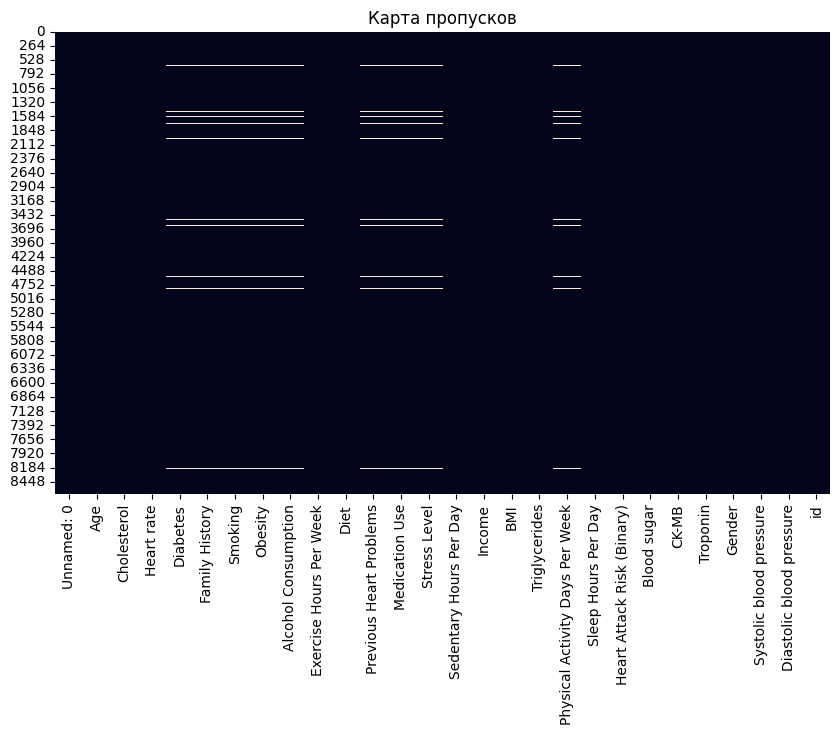

In [16]:
missing_vals = df_train.isnull().sum()
missing_pct = (missing_vals / len(df_train)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_vals, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Values'] > 0])

plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cbar=False)
plt.title('Карта пропусков')
plt.show()

Для 243 пациентов из тренировочной выборки не указана часть данных

In [17]:
missing_rows_test = df_test[df_test.isnull().any(axis=1)]

In [18]:
len(missing_rows_test['id'].unique())

31

In [19]:
print(f'Пропущенные значения составляют {round(len(missing_rows_test) / len(df_test) * 100, 2)}% от тестового датасета')

Пропущенные значения составляют 3.21% от тестового датасета


***Количество пропусков составляет ~3% от общего объема данных, считаю, что их можно удалить. Так как восстановить медицинские данные пациентов проблематично.***

In [20]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train = df_train.drop(columns=['Unnamed: 0', 'Previous Heart Problems', 'id'])
df_test = df_test.drop(columns=['Unnamed: 0', 'Income'])

In [21]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({
            '1': 1,
            'Male': 1,
            '0': 0,
            'Female': 0
        }).astype(float)
    return df

            

In [22]:
df_train = prepare_df(df_train)

In [23]:
df_train['Gender'].isna().sum()

np.int64(0)

In [24]:
df_train.describe()

Age  Cholesterol  Heart rate  Diabetes  Family History   Smoking  \
count 8442.0000    8442.0000   8442.0000 8442.0000       8442.0000 8442.0000   
mean     0.4490       0.5011      0.0502    0.6521          0.4896    0.9029   
std      0.2328       0.2888      0.0184    0.4763          0.4999    0.2962   
min      0.0449       0.0000      0.0183    0.0000          0.0000    0.0000   
25%      0.2472       0.2607      0.0348    0.0000          0.0000    1.0000   
50%      0.4607       0.4964      0.0504    1.0000          0.0000    1.0000   
75%      0.6404       0.7500      0.0660    1.0000          1.0000    1.0000   
max      0.8539       1.0000      0.0825    1.0000          1.0000    1.0000   

        Obesity  Alcohol Consumption  Exercise Hours Per Week      Diet  \
count 8442.0000            8442.0000                8442.0000 8442.0000   
mean     0.4983               0.6020                   0.5034    1.0015   
std      0.5000               0.4895                   0.2889    0.8130   
min      0.0000               0.0000                   0.0000    0.0000   
25%      0.0000               0.0000                   0.2534    0.0000   
50%      0.0000               1.0000                   0.5082    1.0000   
75%      1.0000               1.0000                   0.7549    2.0000   
max      1.0000               1.0000                   1.0000    2.0000   

       Medication Use  Stress Level  Sedentary Hours Per Day    Income  \
count       8442.0000     8442.0000                8442.0000 8442.0000   
mean           0.5012        5.4934                   0.4991    0.4961   
std            0.5000        2.8679                   0.2894    0.2888   
min            0.0000        1.0000                   0.0000    0.0000   
25%            0.0000        3.0000                   0.2477    0.2446   
50%            1.0000        5.0000                   0.4927    0.4961   
75%            1.0000        8.0000                   0.7510    0.7476   
max            1.0000       10.0000                   1.0000    1.0000   

            BMI  Triglycerides  Physical Activity Days Per Week  \
count 8442.0000      8442.0000                        8442.0000   
mean     0.4968         0.5055                           3.5083   
std      0.2866         0.2904                           2.2818   
min      0.0000         0.0000                           0.0000   
25%      0.2479         0.2571                           2.0000   
50%      0.4908         0.5078                           3.0000   
75%      0.7444         0.7584                           6.0000   
max      1.0000         1.0000                           7.0000   

       Sleep Hours Per Day  Heart Attack Risk (Binary)  Blood sugar     CK-MB  \
count            8442.0000                   8442.0000    8442.0000 8442.0000   
mean                0.5037                      0.3569       0.2280    0.0477   
std                 0.3327                      0.4791       0.0746    0.0704   
min                 0.0000                      0.0000       0.0000    0.0000   
25%                 0.1667                      0.0000       0.2270    0.0482   
50%                 0.5000                      0.0000       0.2270    0.0482   
75%                 0.8333                      1.0000       0.2270    0.0482   
max                 1.0000                      1.0000       1.0000    1.0000   

       Troponin    Gender  Systolic blood pressure  Diastolic blood pressure  
count 8442.0000 8442.0000                8442.0000                 8442.0000  
mean     0.0369    0.6968                   0.4520                    0.5017  
std      0.0593    0.4597                   0.1702                    0.1703  
min      0.0000    0.0000                   0.1613                    0.2093  
25%      0.0365    0.0000                   0.3032                    0.3488  
50%      0.0365    1.0000                   0.4516                    0.5000  
75%      0.0365    1.0000                   0.6000           

**В некоторых столбцах присутствуют нулевые значения, как например в** ***Heart rate,*** **нулевой пульс у живого человека недопустим.**

In [25]:
# Для колонок, которые не являются бинарными, оставим только ненулевые значения.
non_null_columns = [ 'Heart rate', 'BMI', 'Triglycerides', 'Sleep Hours Per Day', 'Blood sugar', 'CK-MB', 'Troponin', 'Diastolic blood pressure', 'Cholesterol','Systolic blood pressure', 'Age']

In [26]:
# перезапишем датасет
df_train = df_train.loc[(df_train[non_null_columns] > 0).all(axis=1)]

In [27]:
num_cols = [
'Age', 'Cholesterol','Heart rate','Income', 'BMI', 'Triglycerides',
'CK-MB', 'Blood sugar', 'Troponin', 'Systolic blood pressure',
'Diastolic blood pressure', 
'Exercise Hours Per Week',
'Sedentary Hours Per Day'
]

In [28]:
cat_cols = [col for col in df_train.columns if col not in num_cols]


In [29]:
class DataPlot:
    def __init__(self):
        pass
        
    def num_plot(self, data, col_list, target='Heart Attack Risk (Binary)'):
        ncols = 2
        nrows = int(np.ceil(len(col_list) / ncols))
    
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
        axes = axes.flatten()
    
        for ax, col in zip(axes, col_list):
            sns.kdeplot(data=data, x=col, hue=target, ax=ax, multiple='stack', common_norm=False)
            ax.set_title(f"{col}", fontsize=16)
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel("Density", fontsize=12)
    
        for i in range(len(col_list), len(axes)):
            axes[i].set_visible(False)
    
        plt.tight_layout()
        plt.suptitle('Распределение Числовых признаков', fontsize=20, y=1.02)
        plt.show()
        
    def cat_plot(self, data, col_list, target='Heart Attack Risk (Binary)'):
        ncols = 2
        nrows = int(np.ceil(len(col_list) / ncols))
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
        axes = axes.flatten()
    
        for ax, col in zip(axes, col_list):
            sns.countplot(data=data, x=col, hue=target, ax=ax)
            ax.set_title(f"{col}", fontsize=16)
            ax.set_xlabel(col, fontsize=12)
            ax.set_ylabel("Count", fontsize=12)
    
            for p in ax.patches:
                height = p.get_height()
                if height > 0:
                    ax.text(p.get_x() + p.get_width() / 2, height + 0.5,
                            f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    
        for i in range(len(col_list), len(axes)):
            axes[i].set_visible(False)
    
        plt.tight_layout()
        plt.suptitle('Распределение категориальных признаков', fontsize=20, y=1.02)
        plt.show()
    def scatter_plot(self, data, col_list, target='Heart Attack Risk (Binary)'):
        ncols = 2
        nrows = int(np.ceil(len(col_list) / ncols))
    
        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 4 * nrows))
        axes = axes.flatten()
    
        for ax, col in zip(axes, col_list):
            sns.scatterplot(x=data.index, y=data[col], hue=data[target], ax=ax, s=10, alpha=0.6)
            ax.set_title(f"{col}", fontsize=16)
            ax.set_xlabel("Индекс", fontsize=12)
            ax.set_ylabel(col, fontsize=12)
    
        for i in range(len(col_list), len(axes)):
            axes[i].set_visible(False)
    
        plt.tight_layout()
        plt.suptitle('Scatterplot числовых признаков', fontsize=20, y=1.02)
        plt.show()

In [30]:
plotter = DataPlot()

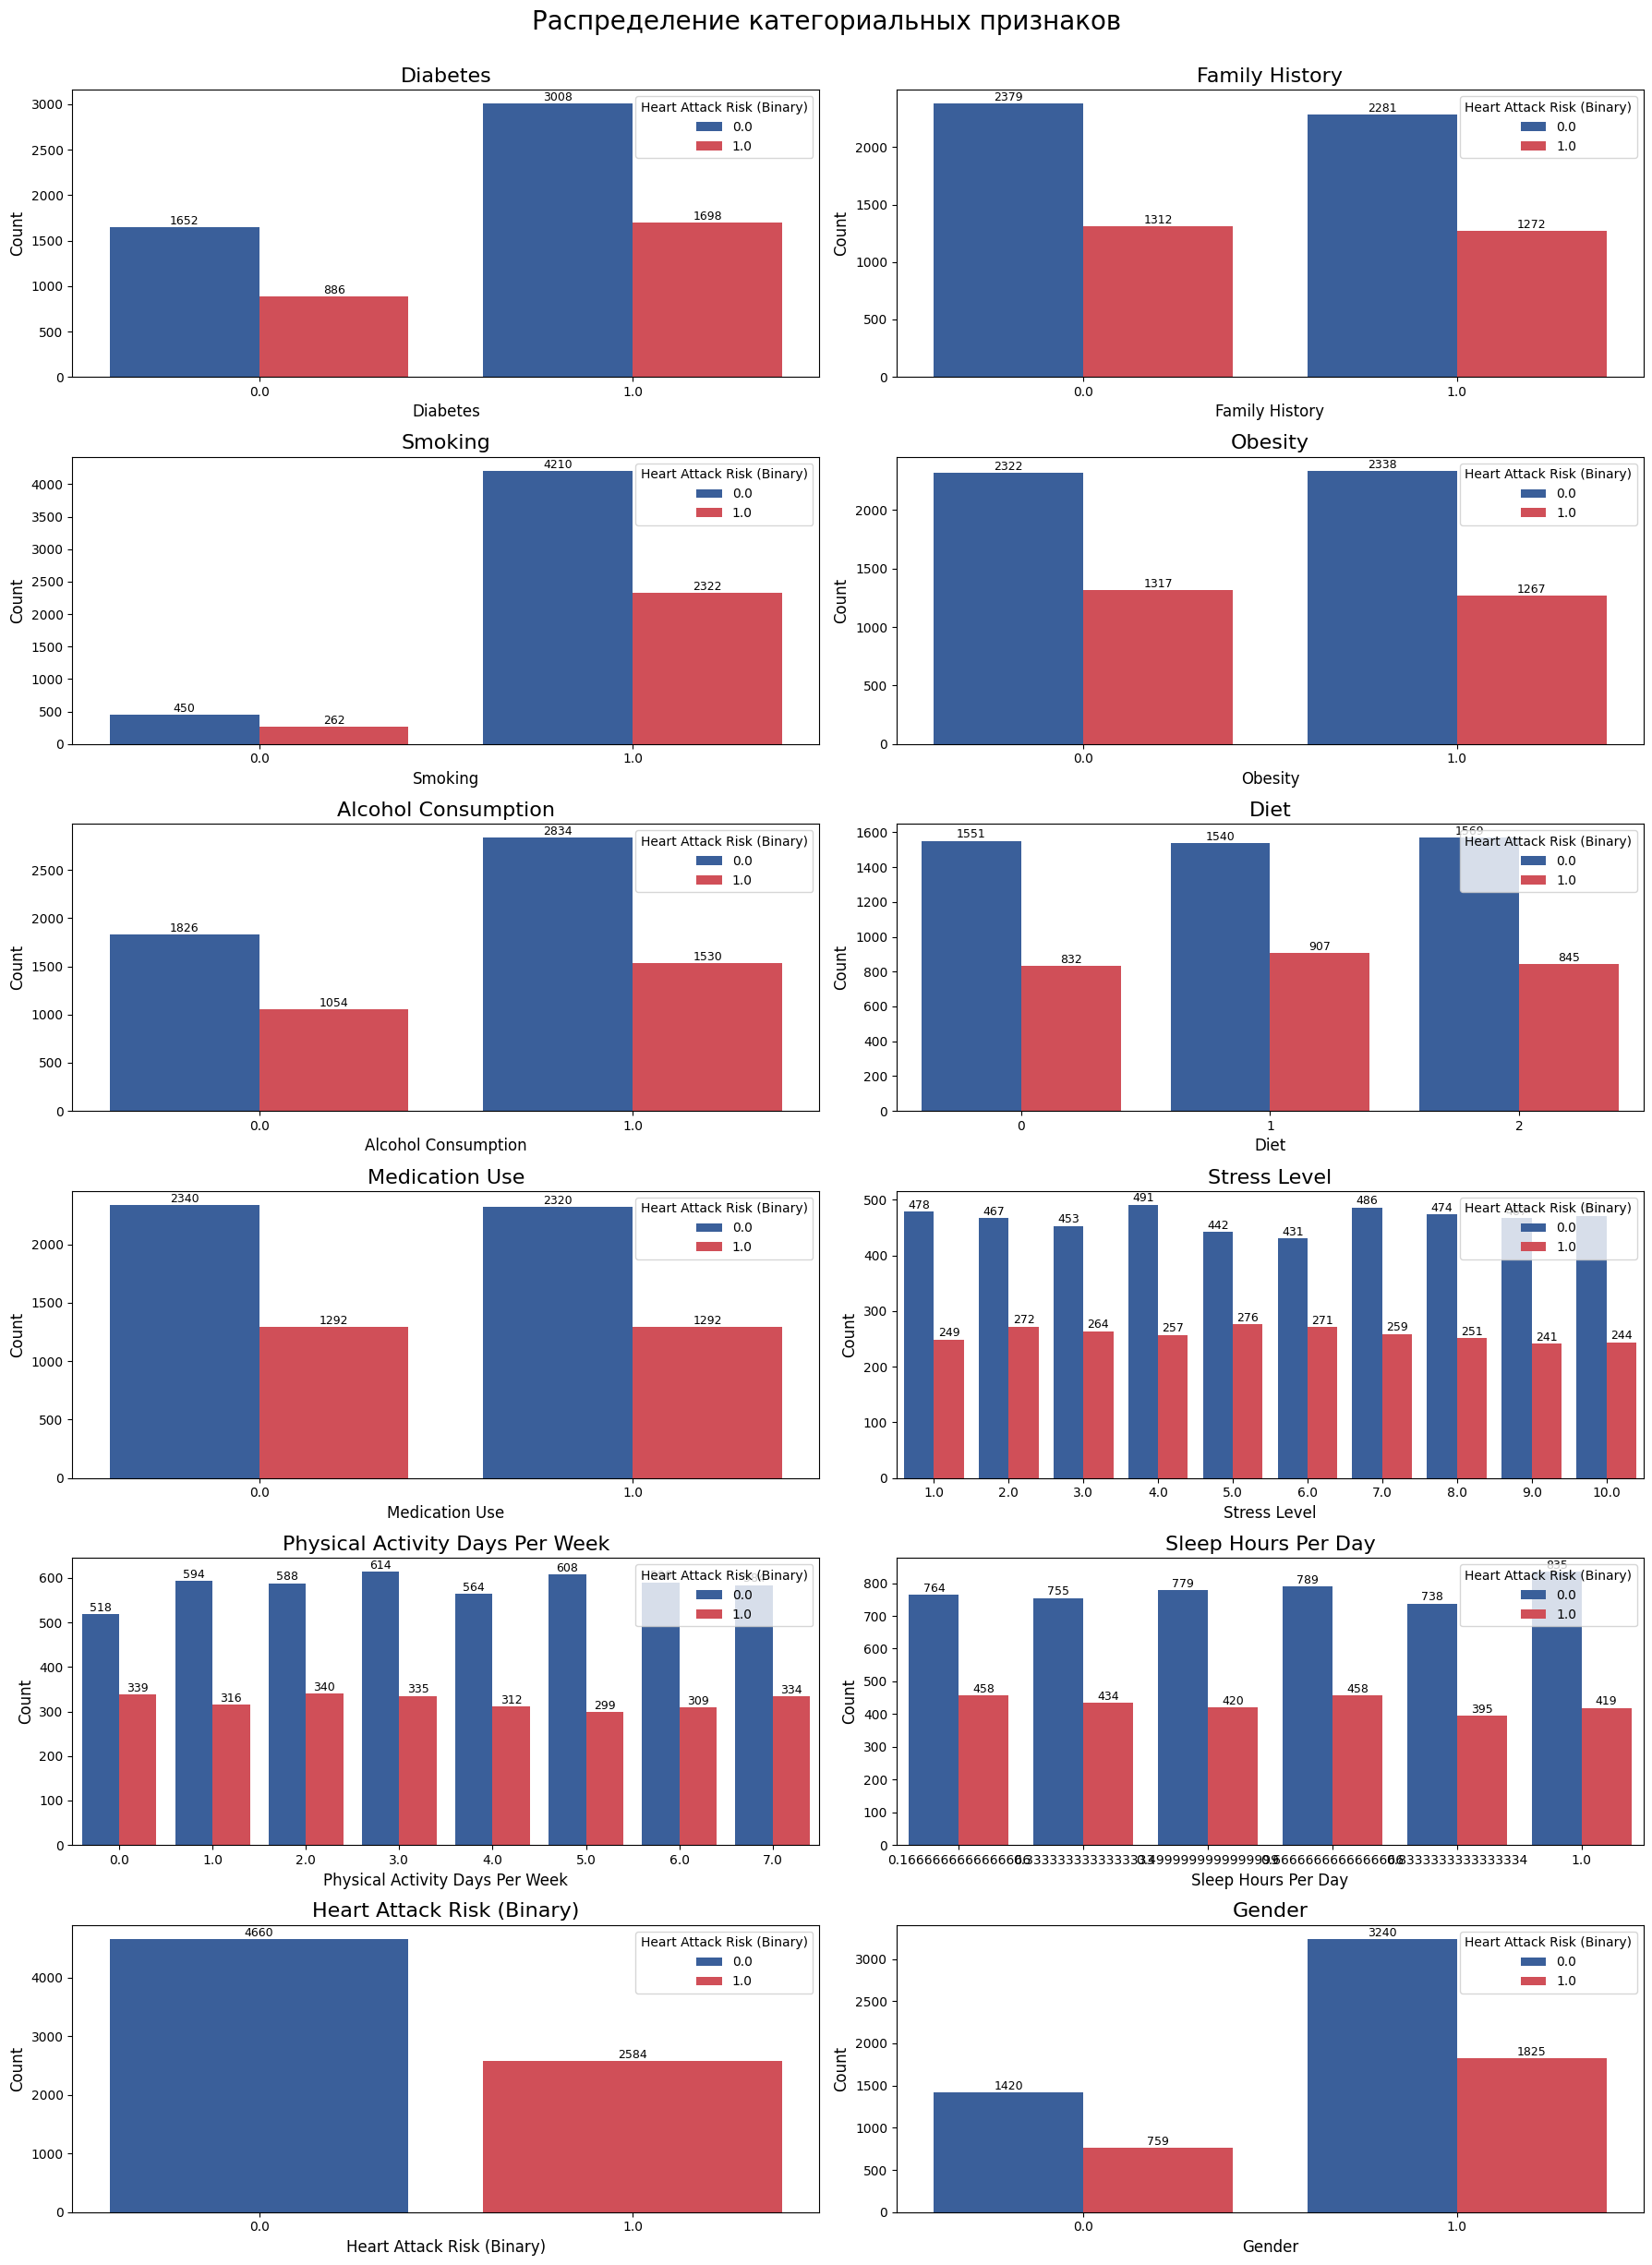

In [31]:
plotter.cat_plot(df_train, cat_cols)

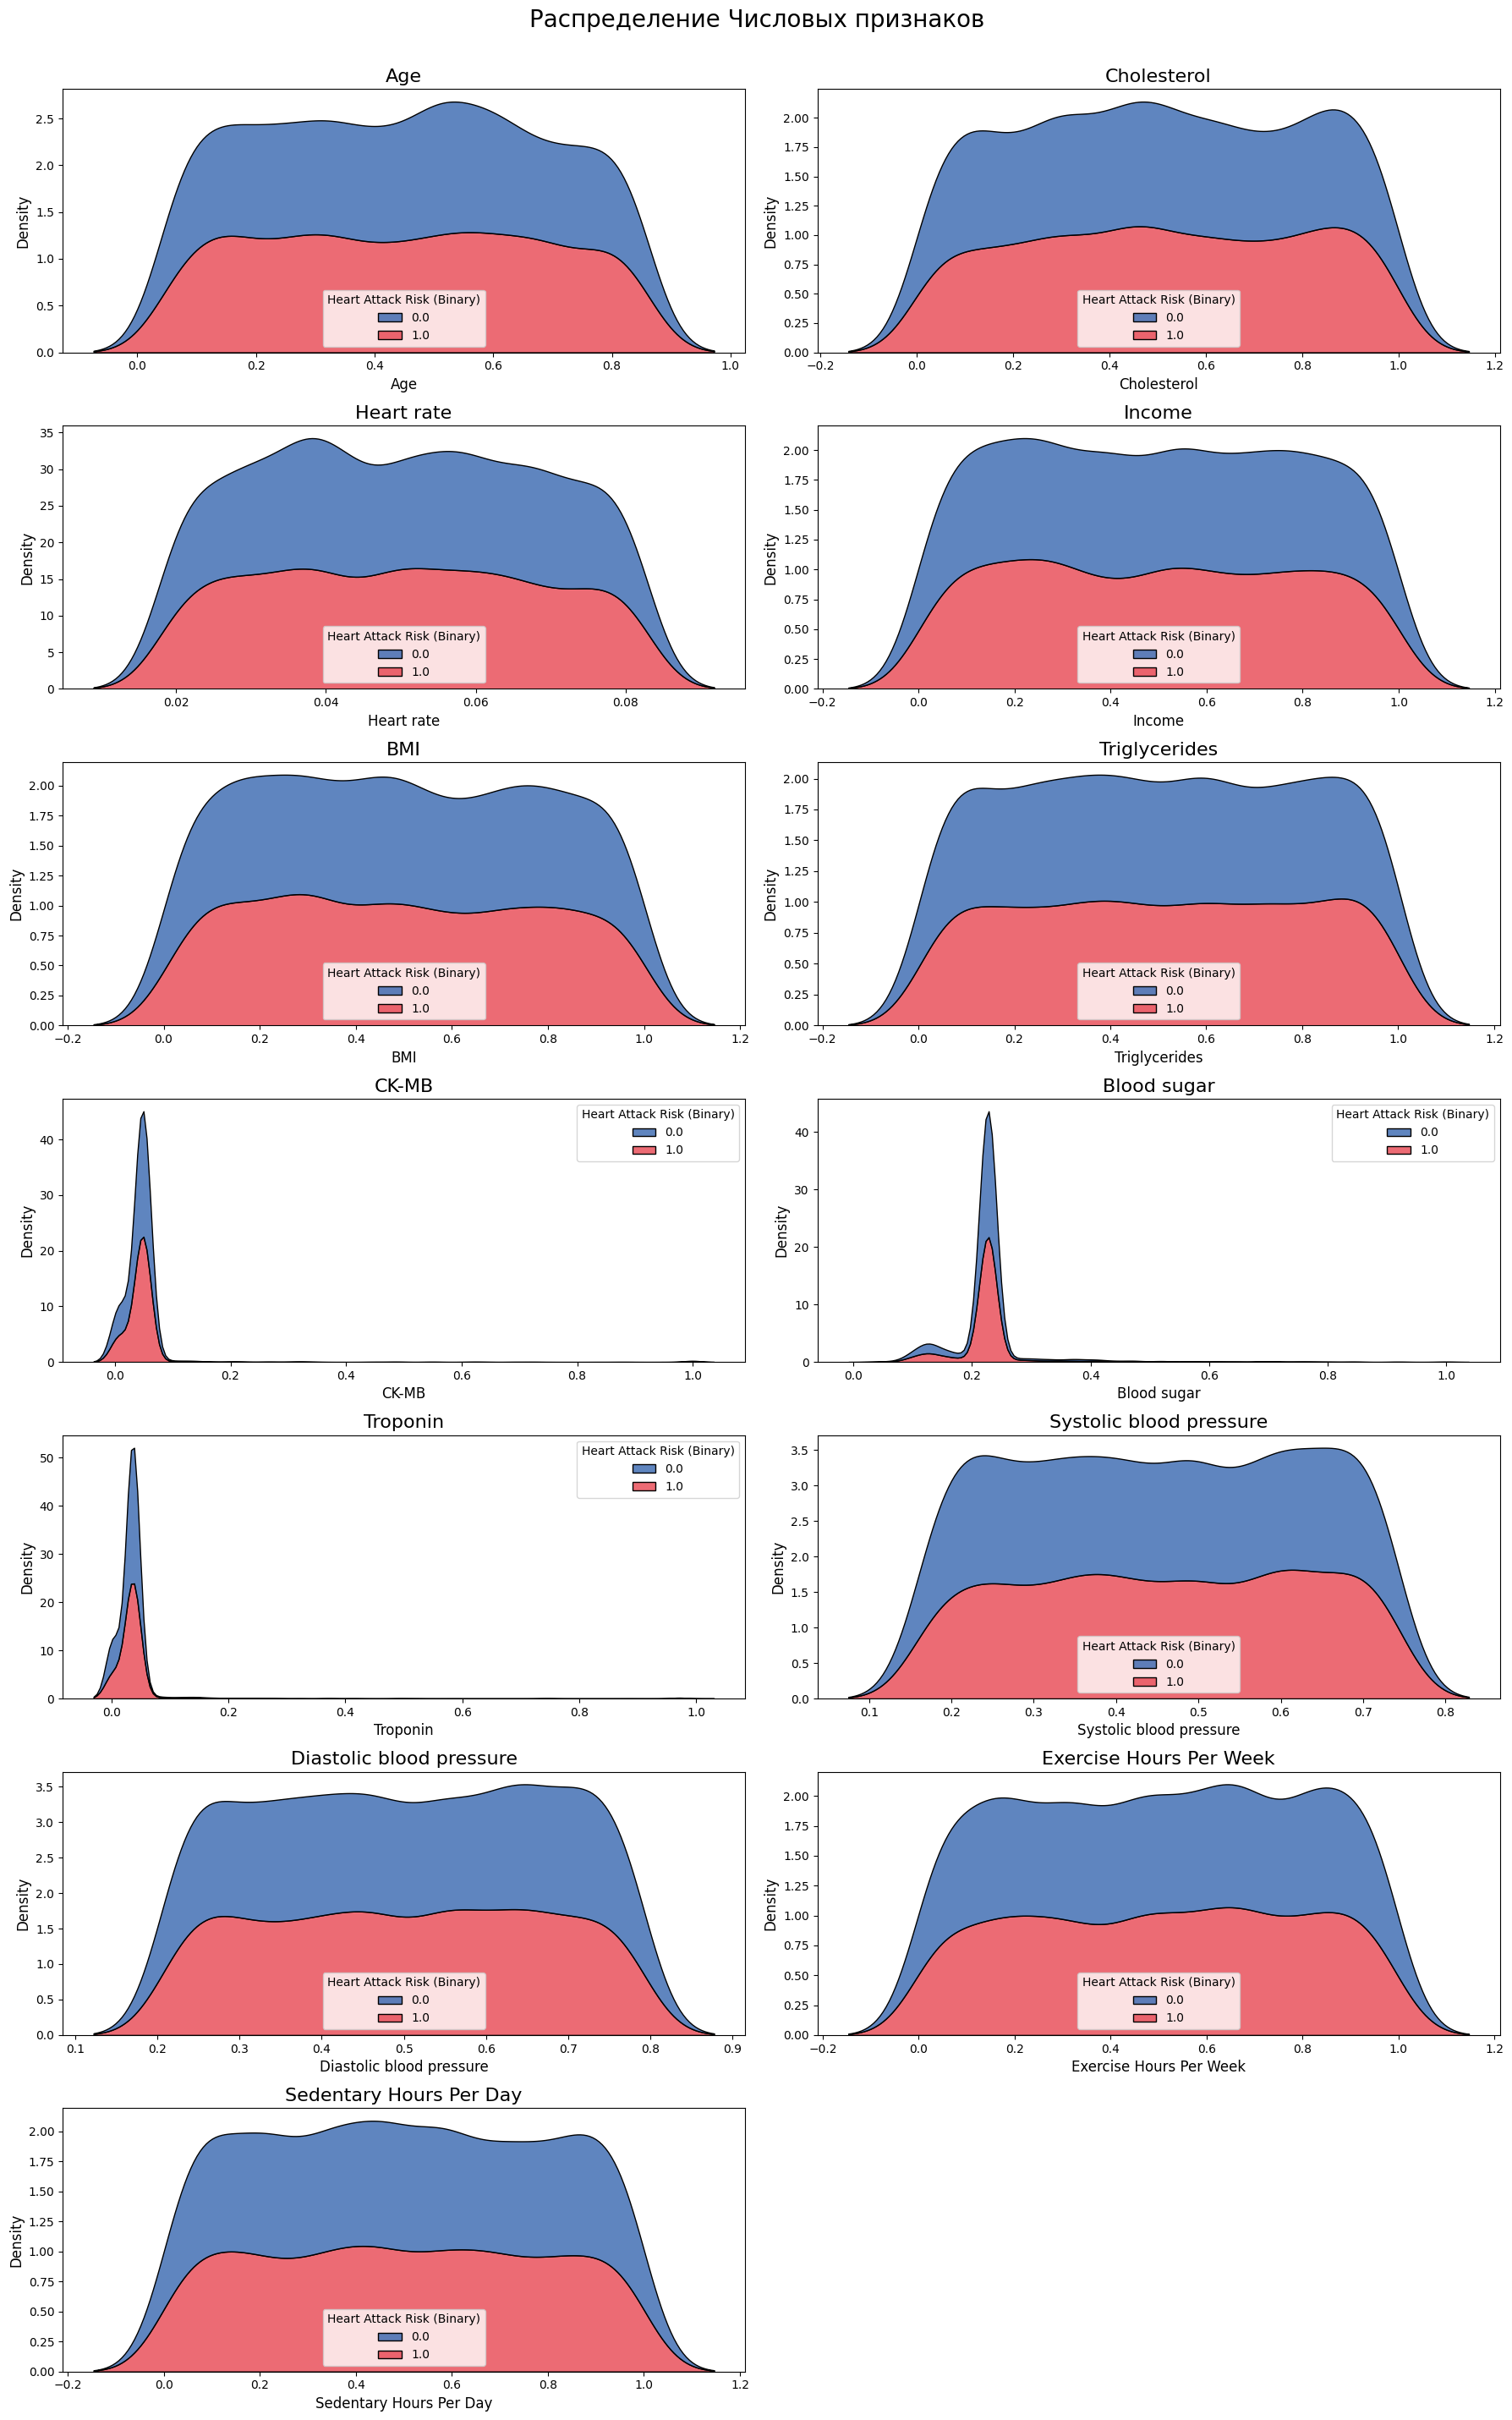

In [32]:
plotter.num_plot(df_train, num_cols)

In [33]:
df_train['Troponin'] = np.where(df_train['Troponin'] > 0,
                                np.log10(df_train['Troponin']),
                                df_train['Troponin'])

df_train['Blood sugar'] = np.where(df_train['Blood sugar'] > 0,
                                   np.log10(df_train['Blood sugar']),
                                   df_train['Blood sugar'])

df_train['CK-MB'] = np.where(df_train['CK-MB'] > 0,
                             np.log10(df_train['CK-MB']),
                             df_train['CK-MB'])

In [34]:
df_train['CK-MB'].describe()

count   7244.0000
mean      -1.4641
std        0.3981
min       -4.0964
25%       -1.3167
50%       -1.3167
75%       -1.3167
max        0.0000
Name: CK-MB, dtype: float64

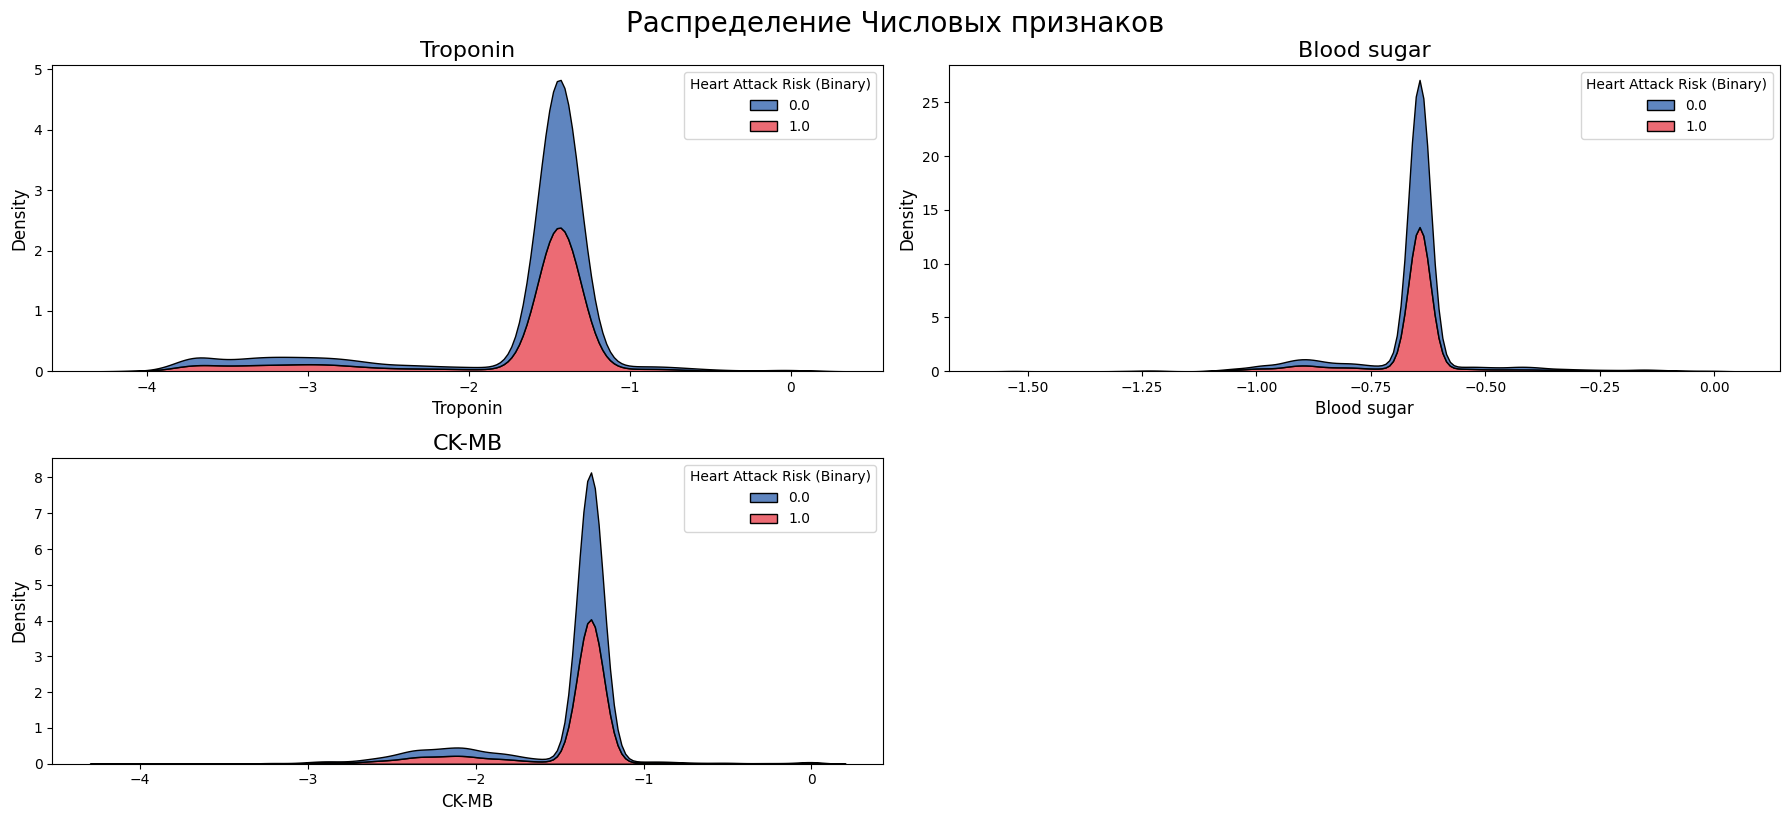

In [35]:
plotter.num_plot(df_train, ['Troponin', 'Blood sugar', 'CK-MB'])

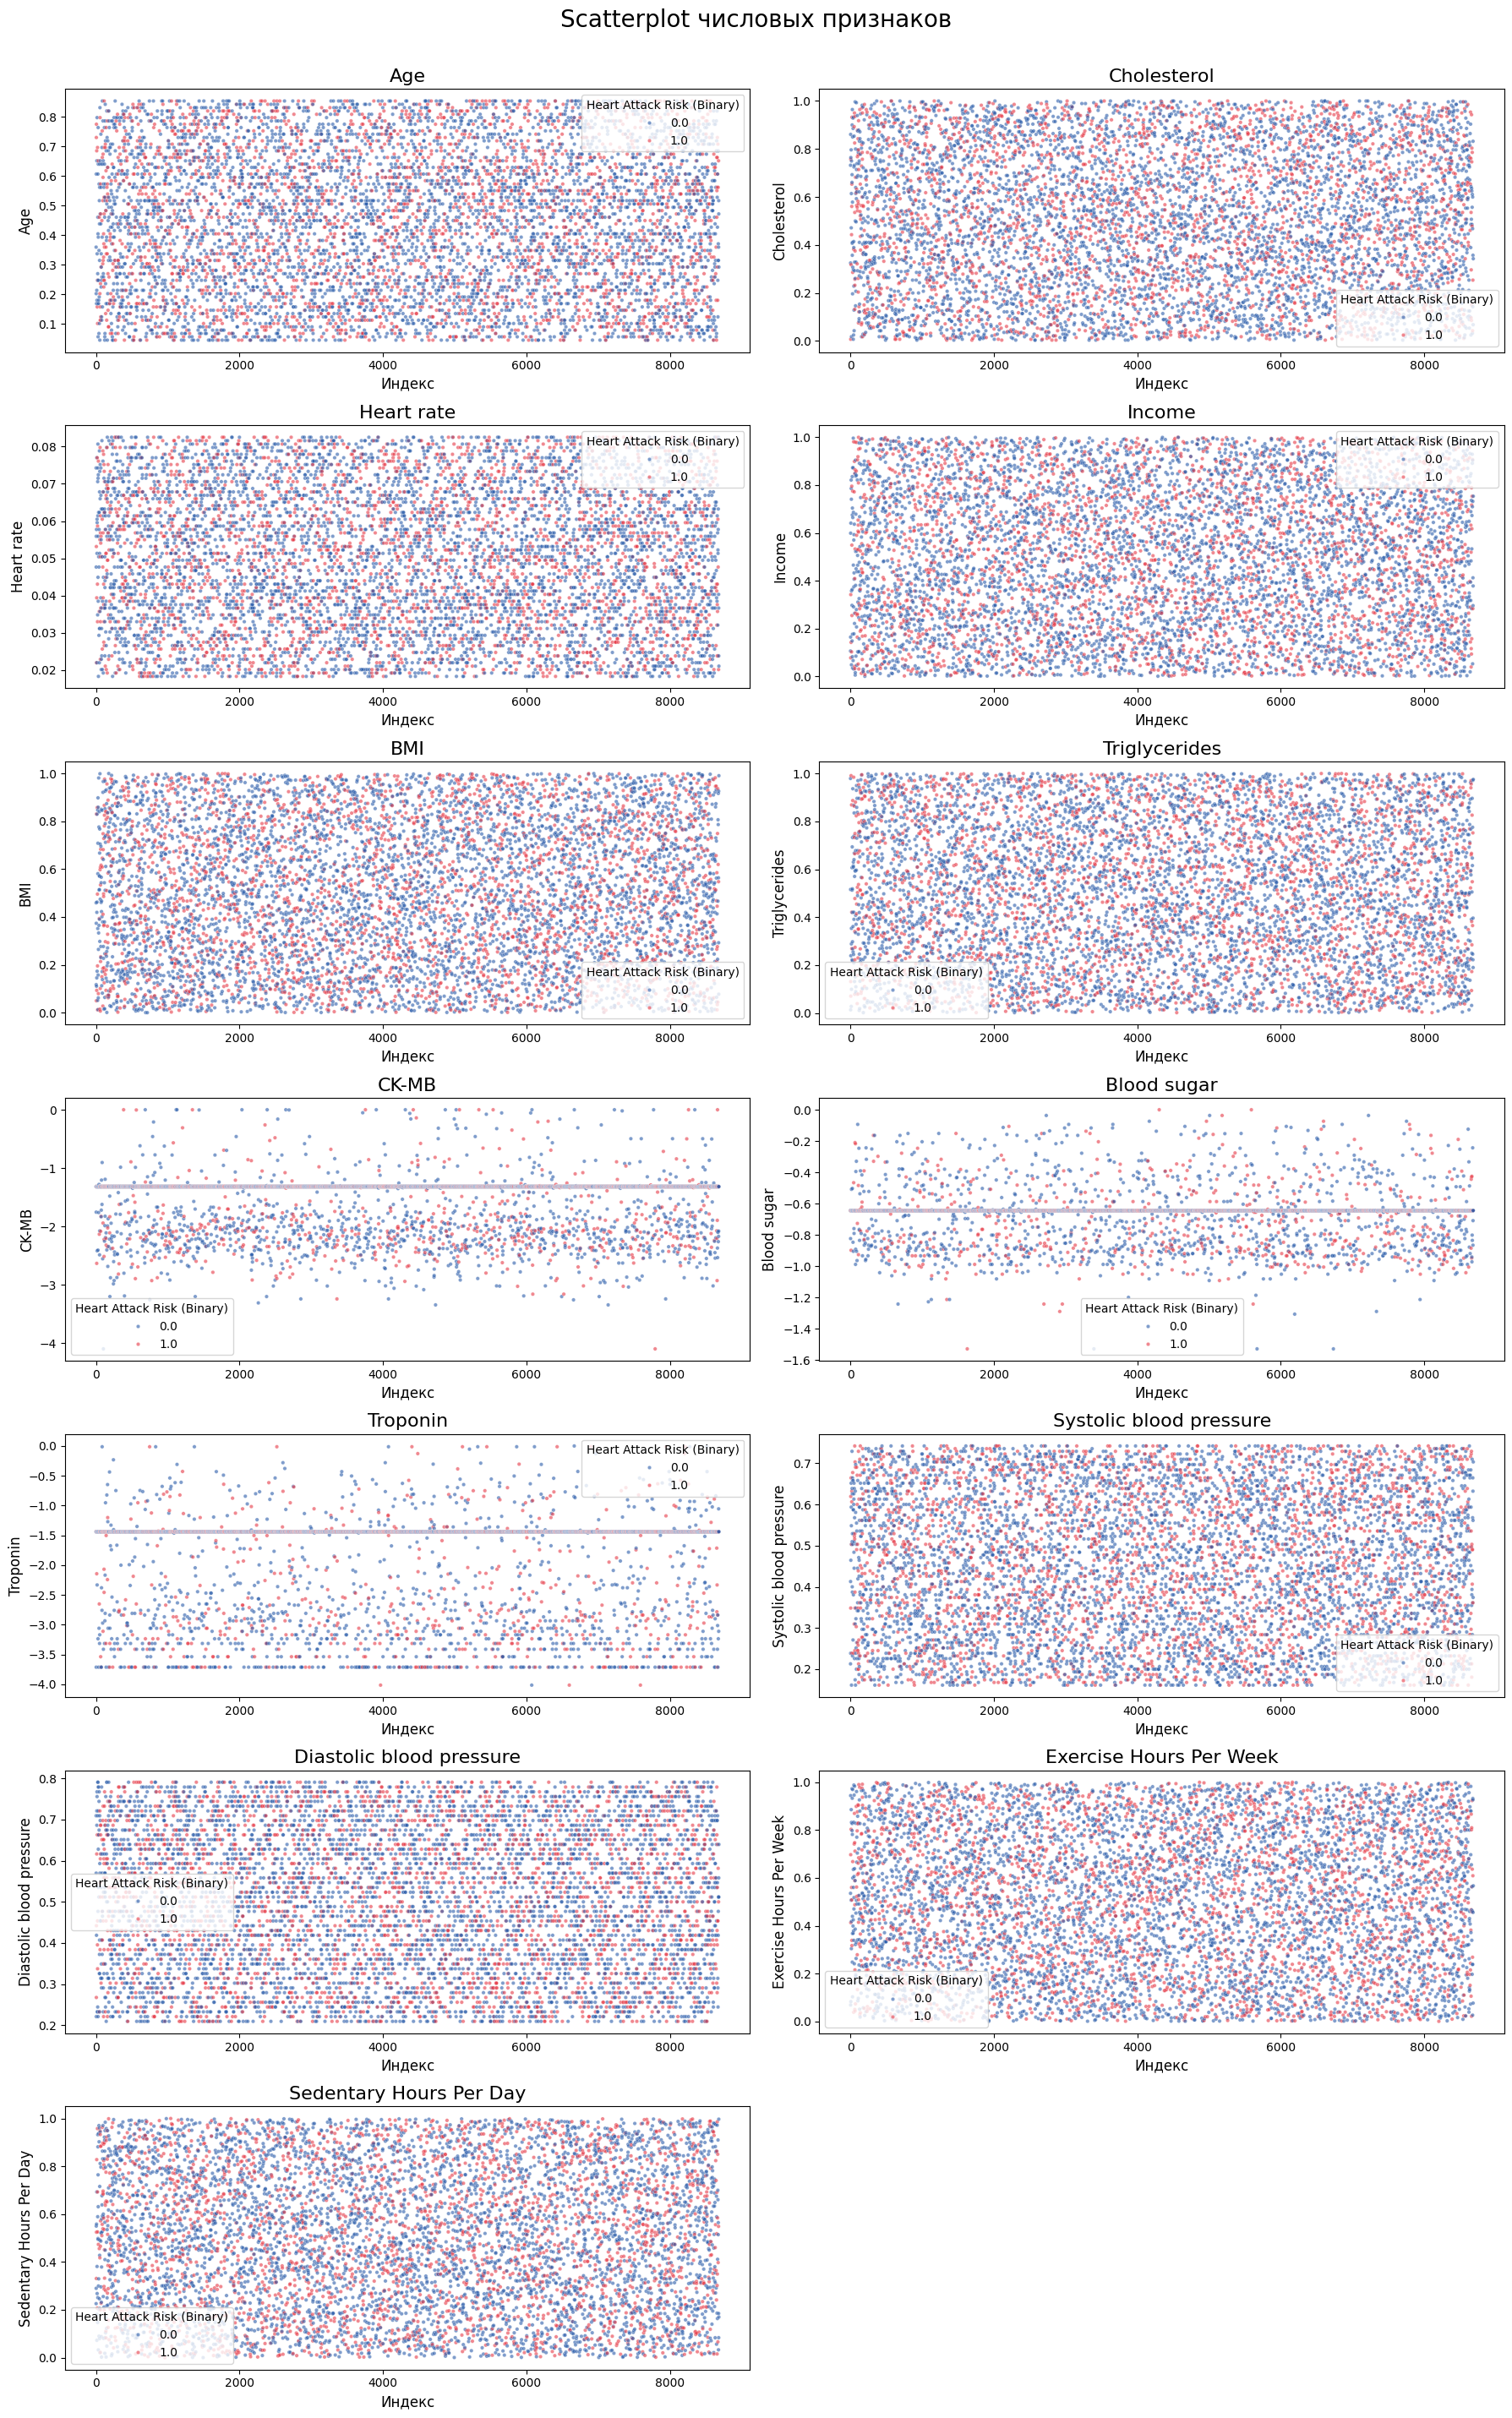

In [36]:
plotter.scatter_plot(df_train, num_cols)

In [37]:
INTERVAL_COLS = df_train.select_dtypes(include='number').columns.drop('Blood sugar')
phik = df_train.phik_matrix(interval_cols=INTERVAL_COLS)

<Axes: >

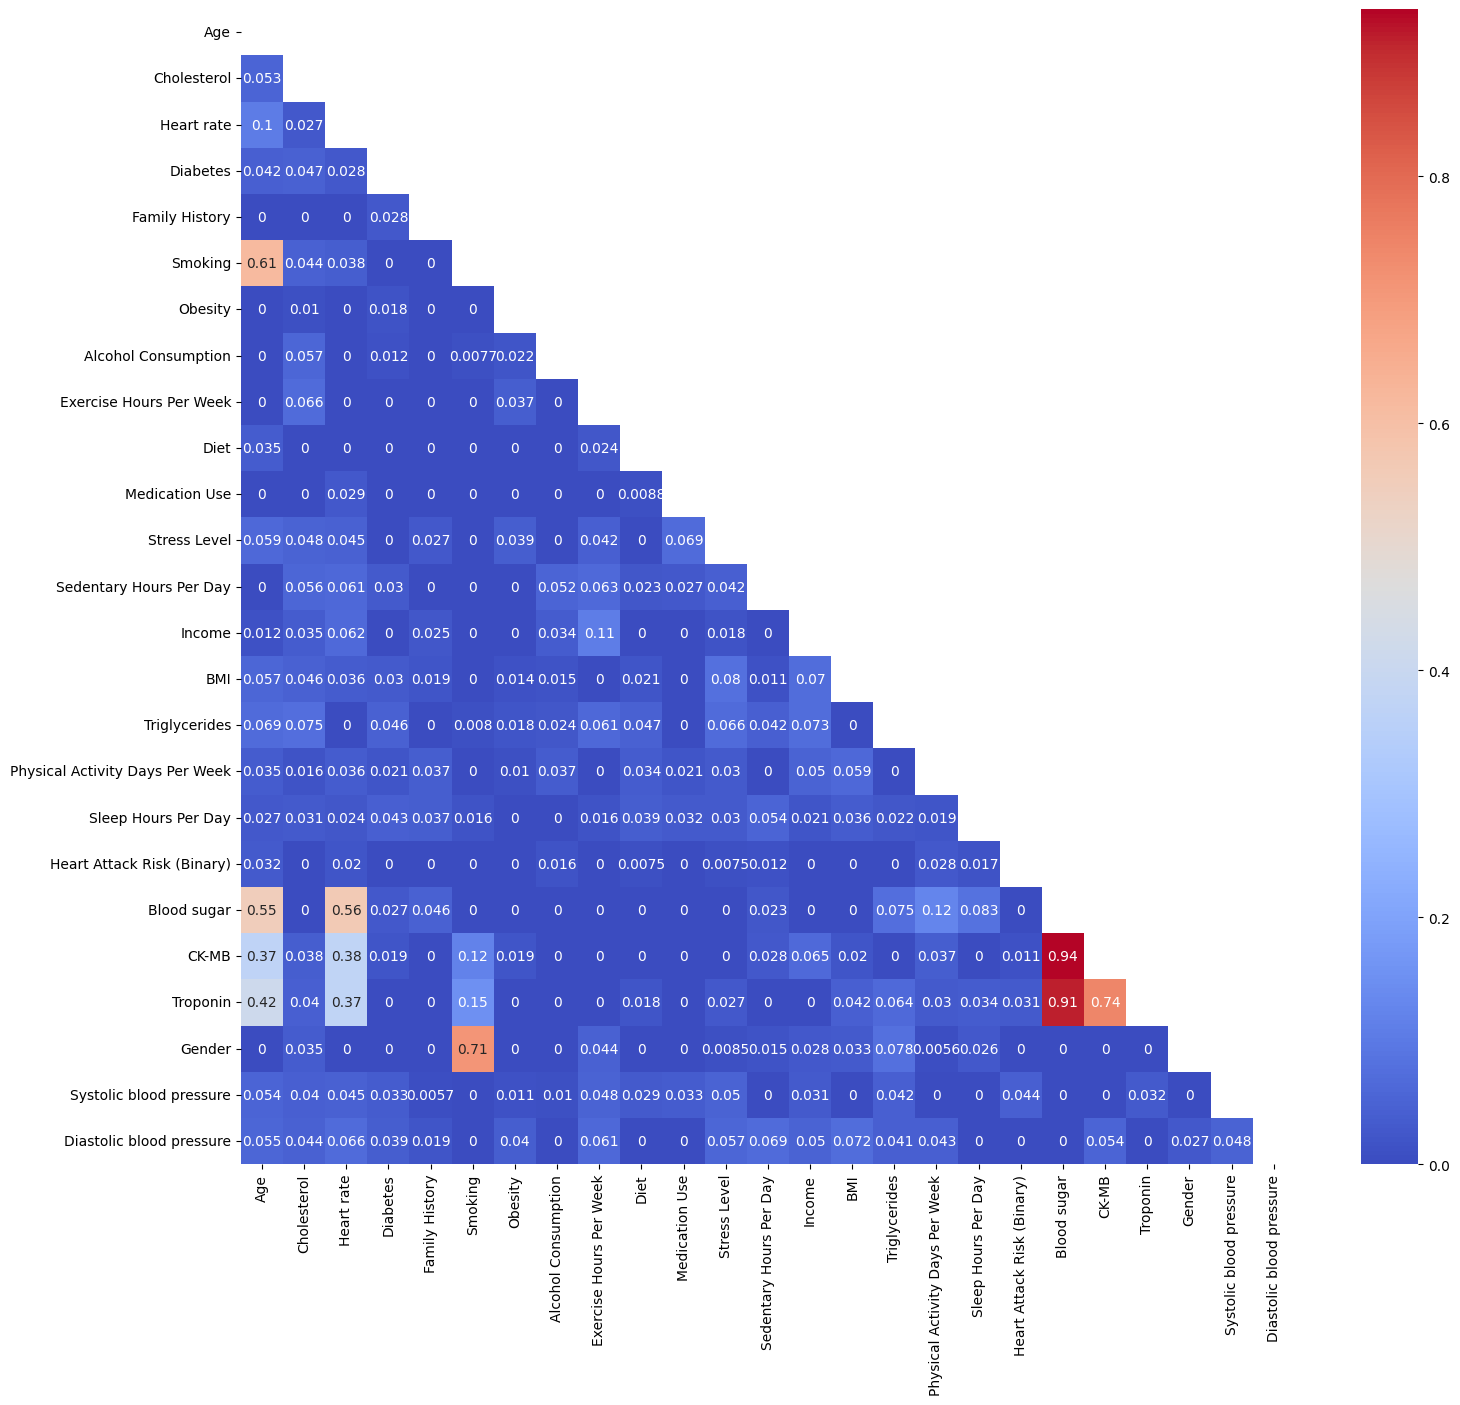

In [38]:
plt.figure(figsize=(17,15))
mask = np.triu(np.ones_like(phik, dtype=bool))
sns.heatmap(phik, annot=True, mask=mask, cmap='coolwarm')

In [39]:
phik_pairs = (
    phik
    .where(~mask)  
    .stack()  
    .reset_index()
)

phik_pairs.columns = ['Признак 1', 'Признак 2', '$\\phi$ Корреляция']

phik_pairs_sorted = phik_pairs.sort_values(by='$\\phi$ Корреляция', ascending=False)

phik_pairs_sorted.head(10)

Признак 1    Признак 2  $\phi$ Корреляция
209        CK-MB  Blood sugar             0.9354
229     Troponin  Blood sugar             0.9101
230     Troponin        CK-MB             0.7440
236       Gender      Smoking             0.7102
10       Smoking          Age             0.6141
173  Blood sugar   Heart rate             0.5628
171  Blood sugar          Age             0.5502
210     Troponin          Age             0.4152
192        CK-MB   Heart rate             0.3757
212     Troponin   Heart rate             0.3733

In [40]:
columns_to_drop = ['Heart Attack Risk (Binary)', 'Income', 'Smoking','Alcohol Consumption','Family History','Gender', 'Blood sugar']


In [41]:
X = df_train.drop(columns=columns_to_drop)
y = df_train['Heart Attack Risk (Binary)']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [43]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Евгений\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [44]:
X_train.describe()

Age  Cholesterol  Heart rate  Diabetes   Obesity  \
count 5433.0000    5433.0000   5433.0000 5433.0000 5433.0000   
mean     0.4423       0.5050      0.0501    0.6477    0.5030   
std      0.2327       0.2882      0.0184    0.4777    0.5000   
min      0.0449       0.0036      0.0183    0.0000    0.0000   
25%      0.2472       0.2643      0.0348    0.0000    0.0000   
50%      0.4494       0.5000      0.0504    1.0000    1.0000   
75%      0.6292       0.7607      0.0660    1.0000    1.0000   
max      0.8539       1.0000      0.0825    1.0000    1.0000   

       Exercise Hours Per Week      Diet  Medication Use  Stress Level  \
count                5433.0000 5433.0000       5433.0000     5433.0000   
mean                    0.5008    0.9969          0.4973        5.4640   
std                     0.2892    0.8162          0.5000        2.8712   
min                     0.0000    0.0000          0.0000        1.0000   
25%                     0.2488    0.0000          0.0000        3.0000   
50%                     0.5021    1.0000          0.0000        5.0000   
75%                     0.7514    2.0000          1.0000        8.0000   
max                     0.9999    2.0000          1.0000       10.0000   

       Sedentary Hours Per Day       BMI  Triglycerides  \
count                5433.0000 5433.0000      5433.0000   
mean                    0.4951    0.4942         0.5034   
std                     0.2886    0.2890         0.2907   
min                     0.0000    0.0001         0.0013   
25%                     0.2451    0.2464         0.2545   
50%                     0.4870    0.4862         0.5000   
75%                     0.7463    0.7443         0.7571   
max                     0.9994    0.9998         1.0000   

       Physical Activity Days Per Week  Sleep Hours Per Day     CK-MB  \
count                        5433.0000            5433.0000 5433.0000   
mean                            3.5067               0.5854   -1.4633   
std                             2.2809               0.2851    0.3985   
min                             0.0000               0.1667   -4.0964   
25%                             2.0000               0.3333   -1.3167   
50%                             3.0000               0.6667   -1.3167   
75%                             6.0000               0.8333   -1.3167   
max                             7.0000               1.0000    0.0000   

       Troponin  Systolic blood pressure  Diastolic blood pressure  
count 5433.0000                5433.0000                 5433.0000  
mean    -1.6967                   0.4526                    0.5012  
std      0.6709                   0.1693                    0.1712  
min     -4.0128                   0.1613                    0.2093  
25%     -1.4376                   0.3097                    0.3488  
50%     -1.4376                   0.4516                    0.5000  
75%     -1.4376                   0.6000                    0.6512  
max      0.0000                   0.7419                    0.7907

In [45]:
#to_scale = ['Troponin']

num_features = ['Age','BMI','Cholesterol','Diastolic blood pressure','Exercise Hours Per Week','Heart rate','Physical Activity Days Per Week','Sedentary Hours Per Day','Sleep Hours Per Day', 'Systolic blood pressure','Triglycerides','Troponin','CK-MB']

ohe_features = ['Diabetes','Diet','Medication Use','Obesity']

ordinal_features = ['Stress Level']



# Подскейлим только to_scale
# to_scale_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler())
# ])

# Кодируем порядковые признаки
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Кодируем категориальные (номинальные) признаки
ohe_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer
data_preprocessor = ColumnTransformer([
    #('scaled', to_scale_transformer, to_scale),
    ('ordinal', ordinal_transformer, ordinal_features),
   # ('ohe', ohe_transformer, ohe_features),
    ('passthrough', 'passthrough', num_features)  # передаём уже отмасштабированные числовые как есть
])



# Финальный пайплайн
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', CatBoostClassifier(verbose=0))
])


In [51]:
scoring = make_scorer(recall_score)

param_grid = {

    'model__class_weights' : [[1, 1.2]],
    'model__l2_leaf_reg' : [7,10,13],
    'model__depth' : [2,6,8],
    'model__learning_rate' : [0.01, 0.05],
    'model__random_strength' : [0,2,5],
    'model__bagging_temperature': [1,5,10],

    

}



r_search = RandomizedSearchCV(
pipe,
param_distributions=param_grid,
n_iter=80,
scoring=scoring,
refit=True,
verbose=3,
cv=5,
random_state=RANDOM_STATE,
n_jobs=-1)

In [ ]:
%%time
# Обучение
r_search.fit(X_res, y_res)

In [48]:
y_proba = r_search.predict_proba(X_test)[:,1]
y_pred = r_search.predict(X_test)

In [49]:
best_model = r_search.best_estimator_.named_steps['model']

In [50]:
print("Лучшая модель:\n", best_model)
print("Лучший результат:", round(r_search.best_score_, 4))
print()
print('recall', recall_score(y_test,y_pred))
print()
print('f1', f1_score(y_test,y_pred))
print()
print('roc_auc', roc_auc_score(y_test, y_proba))

Лучшая модель:
Лучший результат: 0.7788

recall 0.694006309148265

f1 0.4721030042918455

roc_auc 0.5139034437657628


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.36      0.46      1177
         1.0       0.35      0.65      0.46       634

    accuracy                           0.46      1811
   macro avg       0.50      0.50      0.46      1811
weighted avg       0.55      0.46      0.46      1811



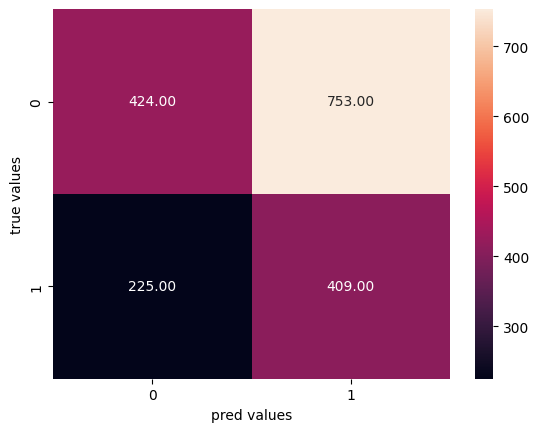

In [51]:
cm =confusion_matrix(y_test,  y_pred)
sns.heatmap(cm, annot=True, fmt='.2f')
plt.ylabel('true values')
plt.xlabel('pred values');

In [52]:
df_test = prepare_df(df_test)

In [53]:
df_test = df_test.loc[(df_test[non_null_columns] > 0).all(axis=1)]

In [54]:
test_columns_to_drop = ['Smoking','Alcohol Consumption','Family History','Gender','Blood sugar']

In [55]:
df_test = df_test.drop('id',axis=1)

In [56]:
df_test =  df_test.drop(columns=test_columns_to_drop)

In [57]:
test = r_search.best_estimator_.predict(df_test)


In [58]:
df_test.head()

Age  Cholesterol  Heart rate  Diabetes  Obesity  Exercise Hours Per Week  \
0 0.4944       0.2643      0.0623    0.0000   1.0000                   0.3616   
1 0.2247       0.9536      0.0825    1.0000   1.0000                   0.9965   
2 0.6292       0.0929      0.0642    0.0000   1.0000                   0.9956   
3 0.4607       0.5679      0.0559    1.0000   1.0000                   0.4373   
5 0.5618       0.7929      0.0266    1.0000   1.0000                   0.7745   

   Diet  Previous Heart Problems  Medication Use  Stress Level  \
0     2                   0.0000          0.0000        8.0000   
1     2                   1.0000          1.0000        5.0000   
2     0                   0.0000          0.0000       10.0000   
3     0                   0.0000          0.0000       10.0000   
5     2                   0.0000          1.0000        8.0000   

   Sedentary Hours Per Day    BMI  Triglycerides  \
0                   0.1944 0.2835         0.3065   
1                   0.3299 0.4670         0.0870   
2                   0.7801 0.4094         0.2052   
3                   0.7851 0.9103         0.1636   
5                   0.0441 0.7234         0.3623   

   Physical Activity Days Per Week  Sleep Hours Per Day  CK-MB  Troponin  \
0                           1.0000               0.3333 0.0482    0.0365   
1                           0.0000               0.1667 0.0482    0.0365   
2                           7.0000               1.0000 0.0027    0.0885   
3                           0.0000               0.6667 0.0564    0.2718   
5                           1.0000               0.6667 0.0482    0.0365   

   Systolic blood pressure  Diastolic blood pressure  
0                   0.2839                    0.3721  
1                   0.7032                    0.4419  
2                   0.4581                    0.7791  
3                   0.7419                    0.2558  
5                   0.1613                    0.5930

In [59]:
y_proba_2 = r_search.best_estimator_.predict_proba(df_test)[:, 1]


In [60]:
predictions =  r_search.best_estimator_.predict(df_test)

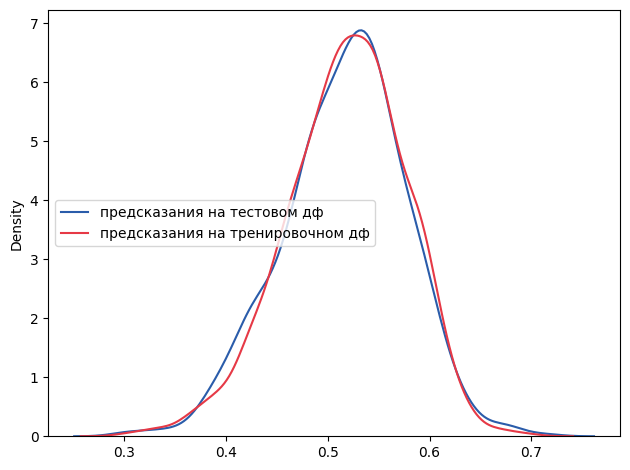

In [61]:
sns.kdeplot(y_proba_2, label='предсказания на тестовом дф')
sns.kdeplot(y_proba, label='предсказания на тренировочном дф')
plt.legend()
plt.tight_layout()

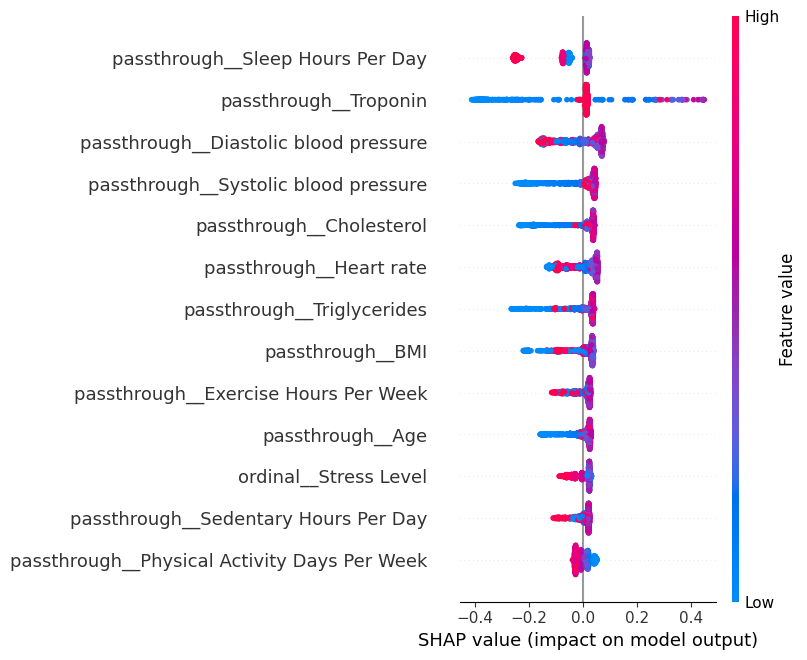

In [63]:
best_pipe = r_search.best_estimator_
model = best_pipe.named_steps['model']
preprocessor = best_pipe.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)
if isinstance(shap_values, list):
    shap_values = shap_values[1]
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)



In [53]:
#joblib.dump(r_search, 'model_best_recall.pkl')


loaded_model = joblib.load('model_best_recall.pkl')


In [58]:
# Предсказания
prediction = loaded_model.predict(df_test)

result_df = pd.DataFrame({
    'id': df_test['id'],           
    'prediction': prediction
})

# Сохранение в CSV
result_df.to_csv('predictions.csv', index=False)


In [59]:
pd.read_csv('predictions.csv')

id  prediction
0    7746      1.0000
1    4202      0.0000
2    6632      0.0000
3    4639      1.0000
4    4825      1.0000
..    ...         ...
930  9271      0.0000
931  8012      1.0000
932  2456      0.0000
933  4984      1.0000
934  6521      0.0000

[935 rows x 2 columns]